In [1]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, precision_recall_curve
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from torch_geometric.nn import BatchNorm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import einops

import lovely_tensors as lt
lt.monkey_patch()

/home/pasquale/miniconda3/envs/gnnleak/lib/python3.12/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/pasquale/miniconda3/envs/gnnleak/lib/python3.12/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "


In [2]:
#%% Data Loading and Preprocessing
print("Loading and preprocessing data...")
graph_data = torch.load('data/graph_data_torch.pt')

Loading and preprocessing data...


/tmp/ipykernel_3700066/1167354728.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load('data/graph_data_torch.pt')


In [3]:
graph_data

{'scenario': tensor[17520000, 1] i32 67Mb x∈[1, 1000] μ=500.500 σ=288.675,
 'node_features': tensor[17520000, 32] n=560640000 (2.1Gb) x∈[0., 69.985] μ=61.383 σ=11.861,
 'edge_attr': tensor[17520000, 34] n=595680000 (2.2Gb) x∈[-3.726e+03, 1.344e+04] μ=835.518 σ=1.509e+03,
 'edge_index': tensor[34, 2] i64 n=68 x∈[0, 31] μ=15.471 σ=9.229,
 'y': tensor[17520000, 32] i64 n=560640000 (4.2Gb) x∈[0, 1] μ=0.008 σ=0.087}

In [4]:
# Temporal parameters
WINDOW_SIZE = 12     
SUBSAMPLE_FACTOR = 5  # Reduced subsampling for more windows
num_nodes = graph_data['node_features'].shape[1]

def preprocess_data(features, window_size, subsample):
    """Process features into [windows, nodes] format with mean, max, min, and std aggregation"""
    # Slice data into overlapping windows
    features = features.unfold(0, window_size, window_size).float()
    
    # Compute mean, max, min, and std pooling within each window
    mean_values = features.mean(dim=2)  # Mean pooling
    max_values = features.max(dim=2).values  # Max pooling
    min_values = features.min(dim=2).values  # Min pooling
    std_values = features.std(dim=2)  # Standard deviation pooling
    
    # Combine mean, max, min, and std into a single representation
    combined_features = torch.cat((mean_values, max_values, min_values, std_values), dim=1)  # Concatenate along feature axis
    
    # Subsample the windows
    return combined_features[::subsample, :]

In [5]:
# Process features and labels
node_features = preprocess_data(graph_data['node_features'], WINDOW_SIZE, SUBSAMPLE_FACTOR)
window_labels = graph_data['y'].unfold(0, WINDOW_SIZE, WINDOW_SIZE).max(dim=2).values[::SUBSAMPLE_FACTOR, :]
window_scenarios = graph_data['scenario'].unfold(0, WINDOW_SIZE, WINDOW_SIZE).mode(dim=2).values[::SUBSAMPLE_FACTOR, :]
print(node_features)
print(window_labels)
print(window_scenarios)

tensor[292000, 128] n=37376000 (0.1Gb) x∈[0., 69.985] μ=46.396 σ=27.862
tensor[292000, 32] i64 n=9344000 (71Mb) x∈[0, 1] μ=0.008 σ=0.088
tensor[292000, 1] i32 1.1Mb x∈[1, 1000] μ=500.502 σ=288.675


In [6]:
scenarios = window_scenarios.unique()
leak_scenarios = window_scenarios[window_labels.any(dim=1)].unique()
non_leak_scenarios = set(scenarios.tolist()) - set(leak_scenarios.tolist())

In [7]:
test_scenarios = np.random.choice(list(leak_scenarios), 10, replace=False)
val_scenarios = np.random.choice(list(non_leak_scenarios - set(test_scenarios.tolist())), 10, replace=False)
train_scenarios = list(set(scenarios.tolist()) - set(test_scenarios.tolist()) - set(val_scenarios.tolist()))

In [8]:
# Identify normal windows (no leaks)
normal_windows = (window_labels == 0).all(dim=1)
print(f"Normal windows: {normal_windows.sum()}/{len(normal_windows)}")

Normal windows: 225488/292000


In [ ]:
train_mask = torch.tensor(np.isin(window_scenarios, train_scenarios))
val_mask = torch.tensor(np.isin(window_scenarios, val_scenarios))
test_mask = torch.tensor(np.isin(window_scenarios, test_scenarios))

In [10]:
# Split normal data into train/val/test (80/10/10)
normal_indices = torch.where(normal_windows)[0]
np.random.shuffle(normal_indices.numpy())
train_idx = normal_indices[:int(0.8*len(normal_indices))]
val_idx = normal_indices[int(0.8*len(normal_indices)):int(0.9*len(normal_indices))]
test_normal_idx = normal_indices[int(0.9*len(normal_indices)):]
print(len(train_idx))
print(len(val_idx))
print(len(test_normal_idx))

180390
22549
22549


In [11]:
# Test set contains all anomalous windows plus 10% normal
test_anomalous_idx = torch.where(~normal_windows)[0]
test_idx = torch.cat([test_normal_idx, test_anomalous_idx])
print(len(test_idx))

89061


In [12]:
# Normalize using training normal data
scaler = StandardScaler()
train_features = scaler.fit_transform(node_features[train_idx].numpy())
val_features = scaler.transform(node_features[val_idx].numpy())
test_features = scaler.transform(node_features[test_idx].numpy())

In [13]:

# Convert to tensors
x_train = torch.tensor(train_features, dtype=torch.float32)
x_val = torch.tensor(val_features, dtype=torch.float32)
x_test = torch.tensor(test_features, dtype=torch.float32)

# Reshape back to [time, nodes, features]
x_train = einops.rearrange(x_train, "w (f n) -> w n f", n=num_nodes)
x_val = einops.rearrange(x_val, "w (f n) -> w n f", n=num_nodes)
x_test = einops.rearrange(x_test, "w (f n) -> w n f", n=num_nodes)

print(x_train)
print(x_val)
print(x_test)

tensor[180390, 32, 4] n=23089920 (88Mb) x∈[-13.791, 14.042] μ=3.806e-10 σ=0.984
tensor[22549, 32, 4] n=2886272 (11Mb) x∈[-13.252, 8.825] μ=-0.003 σ=0.987
tensor[89061, 32, 4] n=11399808 (43Mb) x∈[-17.186, 18.219] μ=-0.246 σ=1.283


In [14]:
#%% Enhanced Model Definition
class LeakDetector(torch.nn.Module):
    def __init__(self, in_dim, hid_dim=1, num_layers=4):
        super().__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(GATConv(in_dim, hid_dim, heads=4))  # GAT with attention
        self.encoder.append(BatchNorm(hid_dim*4))
        for _ in range(num_layers-2):
            self.encoder.append(GATConv(hid_dim*4, hid_dim, heads=4))
            self.encoder.append(BatchNorm(hid_dim*4))
        self.encoder.append(GATConv(hid_dim*4, hid_dim, heads=1))  # Single head for final
        
        self.decoder = torch.nn.ModuleList([
            GATConv(hid_dim, hid_dim),
            GATConv(hid_dim, in_dim)
        ])
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch 
        for layer in self.encoder:
            if isinstance(layer, BatchNorm):
                x = layer(x)
            else:
                x = layer(x, edge_index)
                x = torch.relu(x)
                x = self.dropout(x)
        
        x_recon = x
        for conv in self.decoder[:-1]:
            x_recon = torch.relu(conv(x_recon, edge_index))
        return self.decoder[-1](x_recon, edge_index)

In [15]:
#%% Model Initialization
model = LeakDetector(in_dim=x_train.shape[2], hid_dim=16)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

#%% Training Loop with Early Stopping
BATCH_SIZE = 512
best_val_loss = float('inf')
patience = 0

In [16]:
# Create graph data
x_train_data = [
    Data(
        x=x_train[i],  # Training uses only normal data
        edge_index=graph_data['edge_index'].long().t().contiguous(),
        y=x_train[i]
    )
    for i in range(len(x_train))
]
train_loader = DataLoader(x_train_data, batch_size=BATCH_SIZE, shuffle=True)

x_val_data = [
    Data(
        x=x_val[i],
        edge_index=graph_data['edge_index'].long().t().contiguous(),
        y=x_val[i],
    )
    for i in range(len(x_val))
]
val_batch = next(iter(DataLoader(x_val_data, batch_size=len(x_val), shuffle=False)))

In [17]:
for epoch in range(200):
    model.train()
    total_loss = 0
    
    # Batch training
    for data in train_loader:
        optimizer.zero_grad()
        
        x_recon = model(data)
        loss = torch.mean(torch.abs(data.y - x_recon))  # MAE loss
        
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * len(data)
    
    avg_train_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_recon = model(val_batch)
        val_loss = torch.mean(torch.abs(val_batch.y - val_recon))
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print("Early stopping")
            break
    
    print(f'Epoch {epoch:04d}: Train Loss {avg_train_loss:.4f}, Val Loss {val_loss:.4f}')

Epoch 0000: Train Loss 98.4400, Val Loss 0.2078
Epoch 0001: Train Loss 79.1275, Val Loss 0.1951
Epoch 0002: Train Loss 74.0381, Val Loss 0.1891
Epoch 0003: Train Loss 71.7763, Val Loss 0.1787
Epoch 0004: Train Loss 71.5239, Val Loss 0.1935
Epoch 0005: Train Loss 69.5326, Val Loss 0.1563
Epoch 0006: Train Loss 69.4725, Val Loss 0.1867
Epoch 0007: Train Loss 67.3526, Val Loss 0.1617
Epoch 0008: Train Loss 66.0525, Val Loss 0.1685
Epoch 0009: Train Loss 65.8150, Val Loss 0.1774
Epoch 0010: Train Loss 64.6112, Val Loss 0.1709
Epoch 0011: Train Loss 63.9251, Val Loss 0.1655
Epoch 0012: Train Loss 60.9171, Val Loss 0.1811
Epoch 0013: Train Loss 60.7723, Val Loss 0.1755
Epoch 0014: Train Loss 60.7109, Val Loss 0.1729
Early stopping


In [18]:
x_test_data = [
    Data(
        x=x_test[i],
        edge_index=graph_data['edge_index'].long().t().contiguous(),
        y=x_test[i],
    )
    for i in range(len(x_test))
]
test_batch = next(iter(DataLoader(x_test_data, batch_size=len(x_test), shuffle=False)))

/tmp/ipykernel_3700066/1310818040.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



=== Detection Performance ===
Precision: 0.752
Recall:    0.969
F1-score:  0.847
ROC-AUC:   0.669


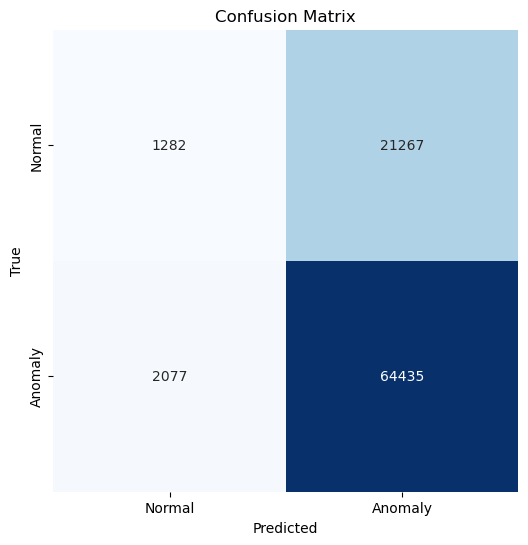

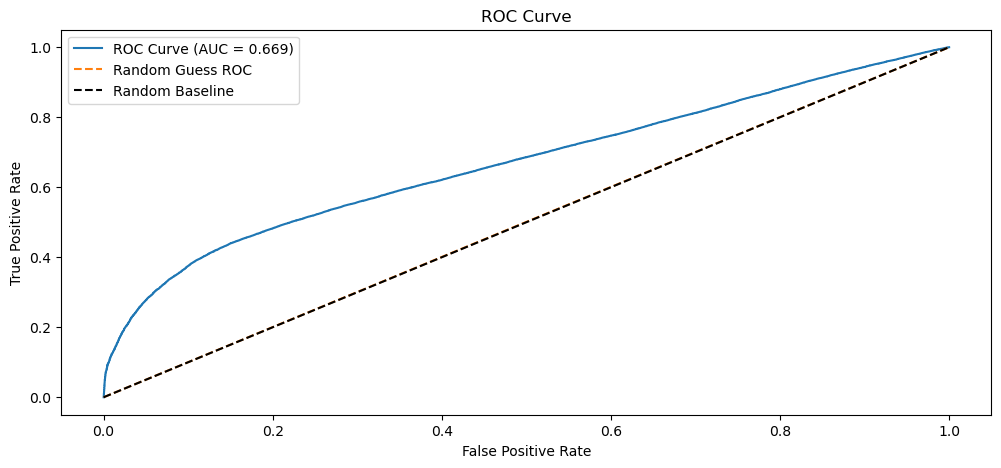

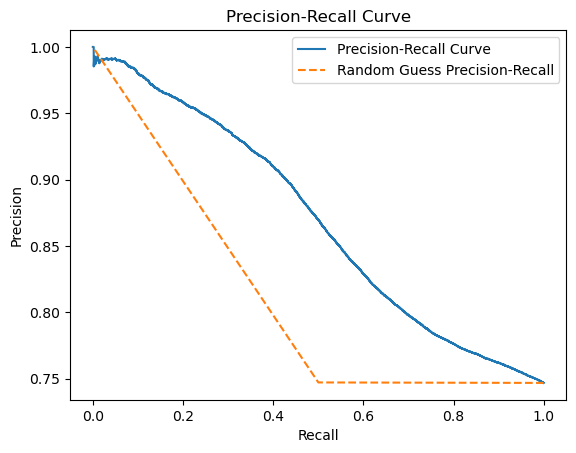

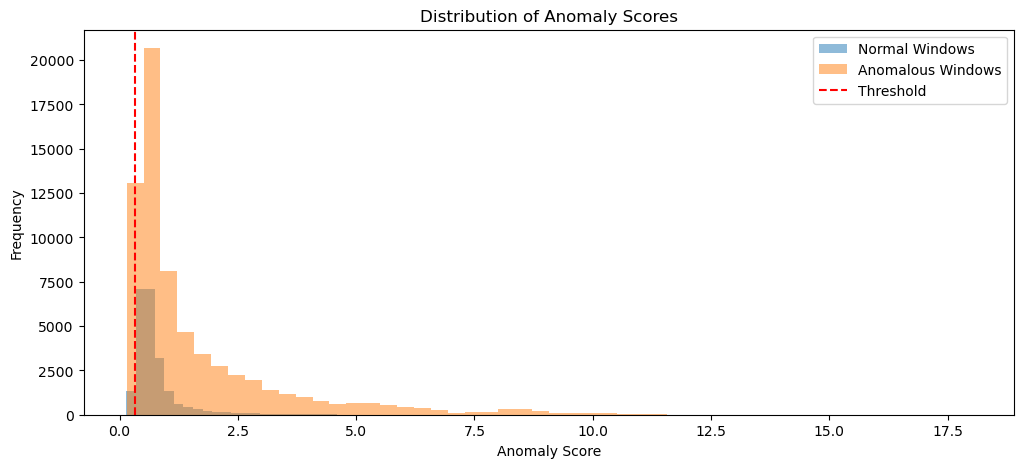


Analysis complete! Results saved to window_anomalies.parquet


In [19]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

#%% Anomaly Detection
model.eval()
with torch.no_grad():
    # Get reconstruction for test data
    test_recon = model(test_batch)
    
    # Calculate node-level errors (MAE)
    node_errors = torch.abs(test_batch.x - test_recon)  # [num_test_windows, num_nodes]
    
    # Get max error per window
    window_scores = node_errors.max(dim=1).values.numpy()

# Calculate threshold using validation normal data (80th percentile)
with torch.no_grad():
    val_recon = model(val_batch)
    val_errors = torch.abs(val_batch.y - val_recon).max(dim=1).values.numpy()
threshold = np.quantile(val_errors, 0.80)  # Lowered to 80th percentile

# Detect anomalies in test set
anomaly_pred = window_scores > threshold

#%% Evaluation
y_true = window_labels[test_idx]
y_true_graph = y_true.any(axis=1).numpy().astype(int)
y_pred = anomaly_pred.astype(int)

# If a node leaks -> the graph leaks
y_pred_graph = einops.reduce(y_pred, "(b n) -> b", n=num_nodes, reduction="max")
window_scores_graph = einops.reduce(window_scores, "(b n) -> b", n=num_nodes, reduction="max")
anomaly_pred_graph = einops.reduce(anomaly_pred, "(b n) -> b", n=num_nodes, reduction="max")

y_pred_random = torch.randint(0, 2, size=(len(y_true_graph),)).numpy().astype(int)

print("\n=== Detection Performance ===")
precision, recall, f1, _ = precision_recall_fscore_support(y_true_graph, y_pred_graph, average='binary')
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

# Calculate precision, recall, and FPR for random predictions
precision_random, recall_random, _ = precision_recall_curve(y_true_graph, y_pred_random)
fpr_random, tpr_random, _ = roc_curve(y_true_graph, y_pred_random)

# ROC-AUC
roc_auc = roc_auc_score(y_true_graph, window_scores_graph)
print(f"ROC-AUC:   {roc_auc:.3f}")

cm = confusion_matrix(y_true_graph, y_pred_graph)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#%% Additional Visualizations
# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_true_graph, window_scores_graph)
plt.figure(figsize=(12, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot(fpr_random, tpr_random, label='Random Guess ROC', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 2. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true_graph, window_scores_graph)
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.plot(recall_random, precision_random, label='Random Guess Precision-Recall', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 3. Distribution of Anomaly Scores
plt.figure(figsize=(12, 5))
plt.hist(window_scores_graph[y_true_graph == 0], bins=50, alpha=0.5, label='Normal Windows')
plt.hist(window_scores_graph[y_true_graph == 1], bins=50, alpha=0.5, label='Anomalous Windows')
plt.axvline(threshold, c='r', linestyle='--', label='Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()

#%% Save Results
results_df = pd.DataFrame({
    'window_index': np.arange(len(window_scores_graph)),
    'score': window_scores_graph,
    'is_anomaly': anomaly_pred_graph,
    'true_label': y_true_graph
})
results_df.to_parquet('window_anomalies.parquet', index=False)

print("\nAnalysis complete! Results saved to window_anomalies.parquet")


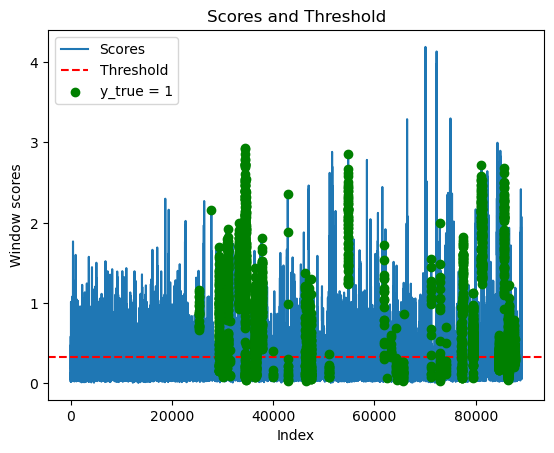

In [20]:
node = 10
window_scores_node = einops.rearrange(window_scores, "(b n) -> b n", n=num_nodes)[:, node]
y_true_node = y_true[:, node]

# Assuming window_scores_node, y_true_node, and threshold are already defined
x = range(len(window_scores_node))

# Plot the window scores
plt.plot(x, window_scores_node, label='Scores')

# Plot the threshold as a dotted line
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Highlight points where y_true_node is 1
highlight_indices = [i for i, val in enumerate(y_true_node) if val == 1]
highlight_scores = [window_scores_node[i] for i in highlight_indices]

plt.scatter(highlight_indices, highlight_scores, color='green', label='y_true = 1', zorder=5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Window scores')
plt.title('Scores and Threshold')

# Add a legend
plt.legend()

# Show the plot
plt.show()